In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import rankdata

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

/Users/dabereabasse/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Téléchargement les données de Yahoo Finance
def get_stock_data(stock, start_date, end_date):
    data = yf.download(stock, start=start_date, end=end_date)
    data.reset_index(inplace=True)
    data['Date'] = pd.to_datetime(data['Date'])
    return data[['Date', 'Adj Close']]

In [3]:
# Calcul des moyennes mobiles et MAD
def calculate_moving_averages(data, short_window=21, long_window=200):
    data = data.copy()
    data['short_ma'] = data['Adj Close'].rolling(window=short_window).mean()
    data['long_ma'] = data['Adj Close'].rolling(window=long_window).mean()
    data['mrat'] = data['short_ma'] / data['long_ma']
    return data

In [4]:
# Assigner les portefeuilles avec rotation périodique
def assign_portfolios(data, rebalance_period='1M', sigma_multiplier=1):
    data = data.copy()
    # Convertir les dates en périodes selon la période de rotation
    data['Rebalance_Period'] = data['Date'].dt.to_period(rebalance_period)

    # Calculer les statistiques de MRAT pour chaque période
    stats = data.groupby(['Rebalance_Period'])['mrat'].agg(['mean', 'std']).reset_index()
    stats.rename(columns={'mean': 'Mean_mrat', 'std': 'std_mrat'}, inplace=True)

    # Joindre les statistiques à l'ensemble de données
    data = data.merge(stats, on=['Rebalance_Period'])

    # Si Date est la dernière date de la période de rééquilibrage
    data['Is_Rebalance_Date'] = data['Date'] == data.groupby('Rebalance_Period')['Date'].transform('last')
    
    # Position pour le mois suivant
    def classify_mad(row):
        if not row['Is_Rebalance_Date']: return np.nan
        if row['mrat'] > 1 + sigma_multiplier * row['std_mrat']: return 'Long' # mrat > mean + multiplier * std ????
        elif row['mrat'] < 1 - sigma_multiplier * row['std_mrat']: return 'Short' # mrat < mean - multiplier * std ????
        else: return 'Neutral'
        
    data['Position'] = data.apply(classify_mad, axis=1).shift(1).ffill()
    
    return data

In [5]:
# Simulation de portefeuille
def simulate_portfolio(data):
    data = data.copy()
    data['returns'] = data['Adj Close'].pct_change()
    data['long_returns'] = data.apply(lambda x: x['returns'] if x['Position'] == 'Long' else 0, axis=1)
    data['short_returns'] = data.apply(lambda x: -x['returns'] if x['Position'] == 'Short' else 0, axis=1)
    data['hedge_returns'] = data['long_returns'] + data['short_returns']
    ret = data[['Date', 'long_returns', 'short_returns', 'hedge_returns']]
    return ret

In [6]:
# Évaluation des performances
def evaluate_performance(returns, benchmark_returns):
    returns = returns.copy().fillna(0)
    benchmark_returns = benchmark_returns.copy().fillna(0)
    
    cumulative_returns = (1 + returns).cumprod() - 1
    cumulative_curve = (1 + returns).cumprod()
    annualized_return = np.mean(returns) * 252
    annualized_volatility = np.std(returns) * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility
    maximum_drawdown = (cumulative_returns.cummax() - cumulative_returns).max()

    # Calcul du maximum drawdown
    rolling_max = cumulative_curve.cummax()
    drawdown = (rolling_max - cumulative_curve) / rolling_max
    maximum_drawdown = drawdown.max()

    # Calcul de l'alpha
    excess_returns = returns - benchmark_returns.mean()
    X = benchmark_returns.values.reshape(-1, 1)
    y = returns.values.reshape(-1, 1)
    model = LinearRegression().fit(X, y)
    alpha = model.intercept_[0] * 252  # Annualisé
    beta = model.coef_[0][0]

    ret = {
        'cumulative_returns': cumulative_returns,
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_volatility,
        'sharpe_ratio': sharpe_ratio,
        'alpha': alpha,
        'beta': beta,
        'max_drawdown': maximum_drawdown,
        'benchmark_annualized_return': np.mean(benchmark_returns) * 252,
    }
    return ret

In [7]:
# Tracé des rendements cumulés
def plot_cumulative_returns(portfolio_returns, benchmark_returns):
    cumulative_portfolio = (1 + portfolio_returns).cumprod() - 1
    cumulative_benchmark = (1 + benchmark_returns).cumprod() - 1

    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_portfolio, label="Portfolio Returns", linewidth=2)
    plt.plot(cumulative_benchmark, label="Benchmark Returns", linewidth=2, linestyle='--')
    plt.title(f"Cumulative Returns")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid()
    plt.show()

In [8]:
# run function
def run_strategy(stock, benchmark, start_date, end_date, rebalance_period, sigma_multiplier):
    stock_data = get_stock_data(stock, start_date, end_date)
    stock_data = calculate_moving_averages(stock_data)
    stock_data = assign_portfolios(stock_data, rebalance_period, sigma_multiplier)
    stock_returns = simulate_portfolio(stock_data)['long_returns']

    benchmark_data = get_stock_data(benchmark, start_date, end_date)
    benchmark_returns = benchmark_data['Adj Close'].pct_change()

    performance = evaluate_performance(stock_returns, benchmark_returns)
    print(f"Annualized Return: {performance['annualized_return']:.2%}")
    print(f"Annualized Volatility: {performance['annualized_volatility']:.2%}")
    print(f"Sharpe Ratio: {performance['sharpe_ratio']:.2f}")
    print(f"Alpha: {performance['alpha']:.2%}")
    print(f"Beta: {performance['beta']:.2f}")
    print(f"Max Drawdown: {performance['max_drawdown']:.2%}")
    print(f"Benchmark Annualized Return: {performance['benchmark_annualized_return']:.2%}")

    plot_cumulative_returns(stock_returns, benchmark_returns)

In [9]:
stock = 'AAPL'
benchmark = 'AAPL'

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Annualized Return: 18.43%
Annualized Volatility: 25.44%
Sharpe Ratio: 0.72
Alpha: -6.30%
Beta: 0.68
Max Drawdown: 31.43%
Benchmark Annualized Return: 36.37%


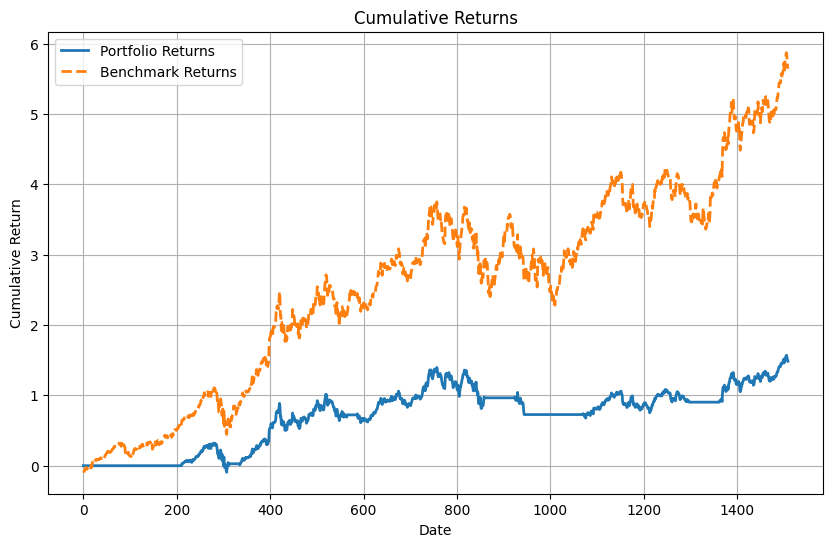

In [10]:
run_strategy(
    stock, 
    benchmark, 
    start_date = '2019-01-01',
    end_date = '2025-01-01',
    rebalance_period='1M',
    sigma_multiplier=1
)

In [11]:
def run_strategy(stocks, benchmark, start_date, end_date, rebalance_period, sigma_multiplier):
    stocks_data = {}
    for stock in stocks:
        stock_data = get_stock_data(stock, start_date, end_date)
        stock_data = calculate_moving_averages(stock_data)
        stock_data = assign_portfolios(stock_data, rebalance_period, sigma_multiplier)
        stocks_data[stock] = simulate_portfolio(stock_data)['long_returns']

    benchmark_data = get_stock_data(benchmark, start_date, end_date)
    benchmark_returns = benchmark_data['Adj Close'].pct_change()

    portfolio_returns = pd.concat(stocks_data.values(), axis=1).replace(0, np.nan).mean(axis=1)
    portfolio_returns = portfolio_returns.fillna(0)

    performance = evaluate_performance(portfolio_returns, benchmark_returns)
    print(f"Annualized Return: {performance['annualized_return']:.2%}")
    print(f"Annualized Volatility: {performance['annualized_volatility']:.2%}")
    print(f"Sharpe Ratio: {performance['sharpe_ratio']:.2f}")
    print(f"Alpha: {performance['alpha']:.2%}")
    print(f"Beta: {performance['beta']:.2f}")
    print(f"Max Drawdown: {performance['max_drawdown']:.2%}")
    print(f"Benchmark Annualized Return: {performance['benchmark_annualized_return']:.2%}")

    plot_cumulative_returns(portfolio_returns, benchmark_returns)

In [12]:
tickers_sp500 = [
    'NVDA', 'AAPL', 'MSFT', 'AMZN', 'META', 'TSLA', 'GOOGL', 'AVGO', 'GOOG',
    'JPM', 'LLY', 'V', 'XOM', 'UNH', 'MA', 'COST', 'NFLX', 'HD', 'WMT',
    'PG', 'JNJ', 'CRM', 'BAC', 'ABBV', 'ORCL', 'CVX', 'WFC', 'CSCO', 'MRK',
    'KO', 'NOW', 'ACN', 'TMO', 'ISRG', 'LIN', 'IBM', 'ABT', 'GE', 'PEP',
    'MCD', 'AMD', 'GS', 'DIS', 'ADBE', 'CAT', 'PM', 'QCOM', 'TXN', 'AXP',
    'NEE', 'HON', 'DHR', 'UNP', 'LOW', 'SBUX', 'AMGN', 'GEHC', 'MDT', 'MDLZ',
    'ELV', 'BLK', 'PLD', 'LMT', 'SYK', 'ADP', 'CB', 'ZTS', 'MO', 'BA',
    'SCHW', 'CI', 'GILD', 'FIS', 'USB', 'BDX', 'DUK', 'SO', 'PNC', 'TGT',
    'EL', 'GM', 'MMM', 'COP', 'NSC', 'ICE', 'MMC', 'APD', 'ITW', 'ADI',
    'ETN', 'EW', 'HUM', 'ILMN', 'CL', 'VRTX', 'TJX', 'SHW', 'CSX', 'FDX',
    'COF', 'BSX', 'WM', 'EMR', 'AON', 'KLAC', 'MCO', 'ECL', 'FCX', 'PSA',
    'MCK', 'ROP', 'AEP', 'NOC', 'IDXX', 'D', 'CTSH', 'TRV', 'KMB', 'TEL',
    'SPG', 'APTV', 'MAR', 'ROST', 'AIG', 'PRU', 'MS', 'SYY', 'PH', 'SLB',
    'LRCX', 'ORLY', 'REGN', 'F', 'WBA', 'BIIB', 'MET', 'A', 'AZO', 'MNST',
    'ADM', 'PSX', 'LHX', 'IQV', 'CTAS', 'DLR', 'SRE', 'BAX', 'HPQ', 'STZ',
    'ALL', 'WELL', 'PAYX', 'EOG', 'PPG', 'CMG', 'MPC', 'CME', 'DLTR', 'ROK',
    'WMB', 'MTD', 'YUM', 'ANSS', 'OTIS', 'PCAR', 'WEC', 'AMP', 'HLT', 'BKR',
    'TT', 'VLO', 'DHI', 'ROKU', 'EBAY', 'EXC', 'PGR', 'MSI', 'HCA', 'KMI',
    'RMD', 'BK', 'DTE', 'ED', 'ES', 'PEG', 'AFL', 'VRSK', 'GPN', 'TDG',
    'SWK', 'HSY', 'FAST', 'ALGN', 'VFC', 'MLM', 'RSG', 'KEYS', 'MTB',
    'HIG', 'EFX', 'AVB', 'SBAC', 'CBRE', 'EXPE', 'TSCO', 'TTWO', 'FITB',
    'DOV', 'ZBH', 'MKC', 'VTR', 'STT', 'IR', 'WAT', 'NTRS', 'LUV', 'GLW',
    'HPE', 'CAG', 'CDW', 'DRI', 'ETSY', 'AKAM', 'HES', 'LEN', 'CFG', 'LVS',
    'HOLX', 'VMC', 'PAYC', 'KMX', 'AAP', 'URI', 'NDAQ', 'CNP', 'AES',
    'IP', 'PPL', 'AEE', 'CMS', 'UAL', 'LNT', 'NRG', 'AAL', 'ALK', 'NCLH',
    'RCL', 'HBI', 'LB', 'NWSA', 'NWS', 'WBD', 'FOX', 'FOXA',
    'PARA', 'VNT', 'WAB', 'WY', 'XEL', 'ZBRA', 'ZION'
][:10]

benchmark = '^GSPC' # S&P 500

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Annualized Return: 35.02%
Annualized Volatility: 26.58%
Sharpe Ratio: 1.32
Alpha: 18.61%
Beta: 1.01
Max Drawdown: 34.61%
Benchmark Annualized Return: 16.25%


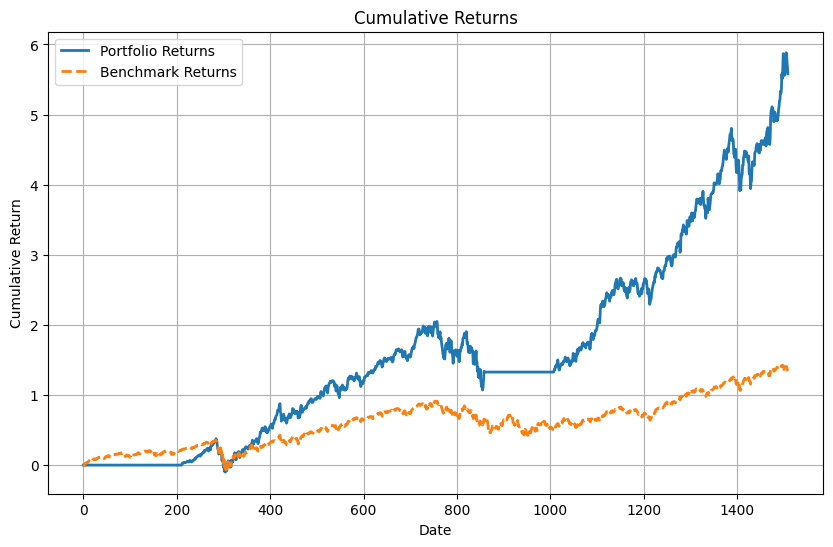

In [13]:
run_strategy(
    tickers_sp500, 
    benchmark, 
    start_date = '2019-01-01',
    end_date = '2025-01-01',
    rebalance_period = '1M',
    sigma_multiplier = 2
)